In [1]:
import os
import csv
import re
import pickle
import random
import math
import dicom
import numpy as np
from tqdm import tqdm
from natsort import natsorted
from skimage import transform
from sklearn.externals import joblib
from scipy import ndimage
from matplotlib import path

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_filepaths():
    with open('../../data_supp/filepaths_train.pkl', 'rb') as f:
        filepaths_train = pickle.load(f)
    with open('../../data_supp/filepaths_val.pkl', 'rb') as f:
        filepaths_val = pickle.load(f)
    return filepaths_train, filepaths_val

In [3]:
def get_ES_frames():
    frame_ES_dict = {}
    
    exclude_from_training = [123, 234, 279, 334, 416, 463, 499]
    
    with open('../../data_supp/ed_es_frame_numbers_training.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for _id, frame_ED, frame_ES, comments in reader:
            if _id not in exclude_from_training:
                frame_ES_dict[int(_id)] = int(frame_ES)
                
    return frame_ES_dict

In [4]:
def apply_window(arr, window_center, window_width):
    return np.clip(arr, window_center - window_width/2, window_center + window_width/2)

In [5]:
def apply_per_slice_norm(arr):
    mean = np.mean(arr.ravel())
    std = np.std(arr.ravel())
    if std == 0:
        return np.zeros(arr.shape)
    return (arr - mean) / std

In [6]:
def crop_to_square_normalized(img_orig, pixel_spacing, size):
    img_norm = ndimage.interpolation.zoom(img_orig, [float(x) for x in pixel_spacing], order=0, mode='constant')
    
    length_x, length_y = img_norm.shape
    if length_x >= size:
        x_start = length_x // 2 - size // 2
        x_end = length_x // 2 + size // 2
    else:
        x_start = 0
        x_end = length_x
    if length_y >= size:
        y_start = length_y // 2 - size // 2
        y_end = length_y // 2 + size // 2
    else:
        y_start = 0
        y_end = length_y
    
    img_new = np.zeros((size, size))
    new_x_shift = (size - (x_end - x_start)) // 2
    new_y_shift = (size - (y_end - y_start)) // 2
    img_new[new_x_shift:(new_x_shift + x_end - x_start), 
            new_y_shift:(new_y_shift + y_end - y_start)] = img_norm[x_start:x_end, y_start:y_end]
    
    return img_new

In [7]:
def create_image_diff_seq(series_filepaths, img_size=256):
    nb_frames = 30
    if len(series_filepaths) != nb_frames:
        return None
            
    # zero-pad 0-index
    image_diff_seq = [np.zeros((img_size, img_size))]
    
    fname, fpath = series_filepaths[0]
    df = dicom.read_file(fpath)
    img_ED = apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, img_size))
    for fname, fpath in series_filepaths[1:]:
        df = dicom.read_file(fpath)
        img_frame = apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, img_size))
        image_diff_seq.append(img_frame - img_ED)
        
    # zero-pad to 32 
    image_diff_seq.append(np.zeros((img_size, img_size)))
    image_diff_seq.append(np.zeros((img_size, img_size)))
        
    return np.array(image_diff_seq).astype(np.float32)

### load dicts

In [8]:
filepaths_train, filepaths_val = get_filepaths()
frame_ES_dict = get_ES_frames()

### visualize sequence of differences

In [9]:
frame_ES_dict[1]

10

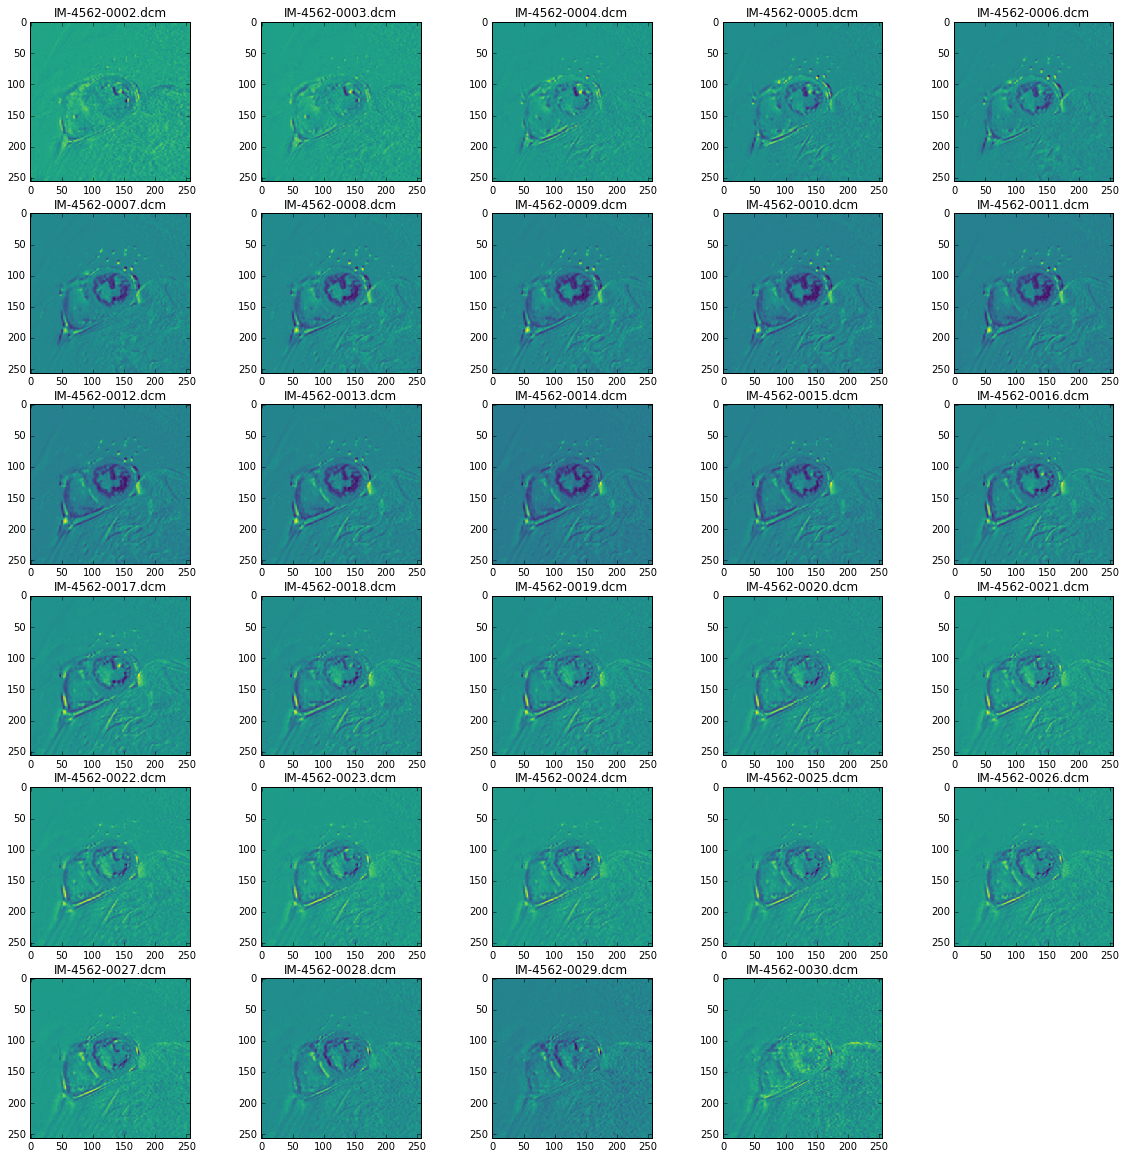

In [11]:
plt.figure(figsize=(20,20))
test_fname, test_fpath = filepaths_train[1]['sax_10'][0]
df = dicom.read_file(test_fpath)
img_ED = apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, 256))
for n, (test_fname, test_fpath) in enumerate(filepaths_train[1]['sax_10'][1:]):
    df = dicom.read_file(test_fpath)
    img_frame = apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, 256))
    plt.subplot(6, 5, n+1)
    plt.title(test_fname)
    plt.imshow(img_frame - img_ED, cmap=plt.cm.viridis)

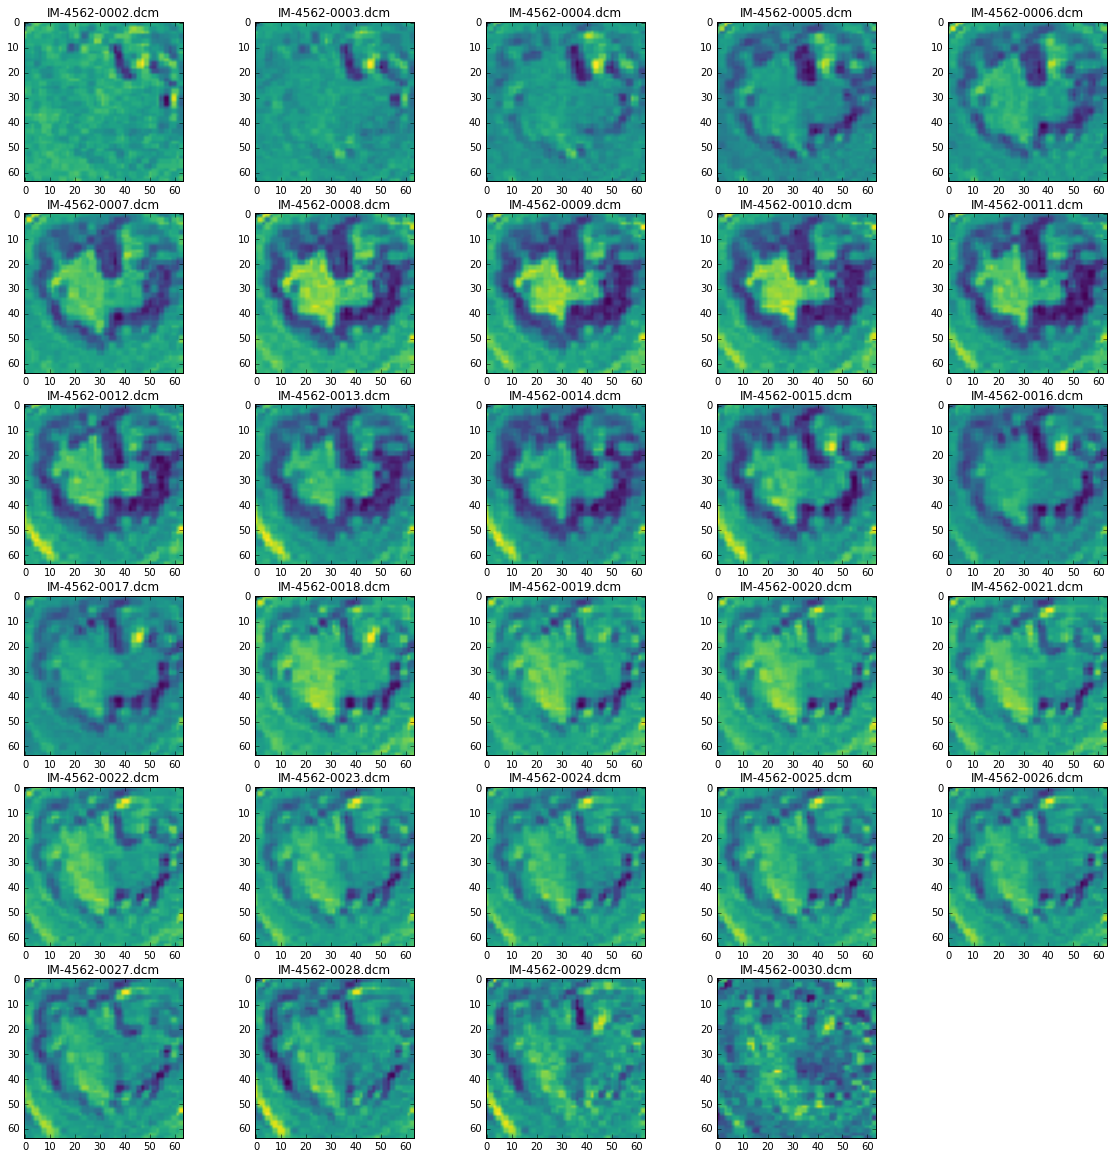

In [13]:
plt.figure(figsize=(20,20))
test_fname, test_fpath = filepaths_train[1]['sax_10'][0]
df = dicom.read_file(test_fpath)
img_ED = apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, 64))
for n, (test_fname, test_fpath) in enumerate(filepaths_train[1]['sax_10'][1:]):
    df = dicom.read_file(test_fpath)
    img_frame = apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, 64))
    plt.subplot(6, 5, n+1)
    plt.title(test_fname)
    plt.imshow(img_frame - img_ED, cmap=plt.cm.viridis)

### preprocess data

In [14]:
exclude_from_training = [123, 234, 279, 334, 416, 463, 499]

study_numbers = [n for n in list(range(1, 501)) if n not in exclude_from_training]

train_val_split = 0.05
study_numbers_train_val = random.sample(study_numbers, int(len(study_numbers) * train_val_split))
study_numbers_train = list(set(study_numbers) - set(study_numbers_train_val))

In [14]:
from keras.utils import np_utils

# training
data_train = []
labels_train = []

# training local validation
data_train_val = []
labels_train_val = []

for study_number in tqdm(filepaths_train.keys()):
    if study_number not in (study_numbers_train + study_numbers_train_val):
        continue
    for series in filepaths_train[study_number].keys():
        if series.startswith('sax'):
            img_diffs = create_image_diff_seq(filepaths_train[study_number][series], img_size=64)
            label = frame_ES_dict[study_number] - 1
            if study_number in study_numbers_train:
                data_train.append(img_diffs)
                labels_train.append(label)
            elif study_number in study_numbers_train_val:
                data_train_val.append(img_diffs)
                labels_train_val.append(label)
            
data_train = np.expand_dims(np.array(data_train), axis=1).astype(np.float32)
#labels_train = np_utils.to_categorical(np.array(labels_train), 32).astype(np.bool)
labels_train = np.array(labels_train).astype(np.uint8)
print(data_train.shape, labels_train.shape)

data_train_val = np.expand_dims(np.array(data_train_val), axis=1).astype(np.float32)
#labels_train_val = np_utils.to_categorical(np.array(labels_train_val), 32).astype(np.bool)
labels_train_val = np.array(labels_train_val).astype(np.uint8)
print(data_train_val.shape, labels_train_val.shape)


(5032, 1, 32, 64, 64) (5032,)
(248, 1, 32, 64, 64) (248,)


In [15]:
joblib.dump((study_numbers_train, study_numbers_train_val, 
             data_train, labels_train, 
             data_train_val, labels_train_val), 
            '../../data_proc/ES_detection_training.pkl')

['../../data_proc/ES_detection_training.pkl',
 '../../data_proc/ES_detection_training.pkl_01.npy',
 '../../data_proc/ES_detection_training.pkl_02.npy',
 '../../data_proc/ES_detection_training.pkl_03.npy',
 '../../data_proc/ES_detection_training.pkl_04.npy']

### training

In [4]:
from keras.models import Sequential, Graph
from keras.layers.core import Activation, Dense, Dropout, Flatten, Merge, Reshape, Lambda
from keras.layers.core import TimeDistributedDense, TimeDistributedMerge
from keras.layers.recurrent import LSTM, GRU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, PReLU, ParametricSoftplus, ELU
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianDropout, GaussianNoise
from keras.utils import np_utils, generic_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

# for preventing python max recursion limit error
import sys
sys.setrecursionlimit(50000)

import 3D convolutional layers
(modified from https://github.com/fchollet/keras/pull/718 by @MinhazPalasara)

In [19]:
from convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D

In [ ]:
es_frame_model = Sequential()
es_frame_model.add(Convolution3D(16, 3, 3, 3, init='he_uniform', border_mode='same', input_shape=(1, 32, 64, 64)))
es_frame_model.add(BatchNormalization())
es_frame_model.add(ELU())
es_frame_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=None, ignore_border=False))
es_frame_model.add(Convolution3D(32, 3, 3, 3, init='he_uniform', border_mode='same'))
es_frame_model.add(BatchNormalization())
es_frame_model.add(ELU())
es_frame_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=None, ignore_border=False))
es_frame_model.add(Convolution3D(64, 3, 3, 3, init='he_uniform', border_mode='same'))
es_frame_model.add(BatchNormalization())
es_frame_model.add(ELU())
es_frame_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=None, ignore_border=False))
es_frame_model.add(Convolution3D(128, 3, 3, 3, init='he_uniform', border_mode='same'))
es_frame_model.add(BatchNormalization())
es_frame_model.add(ELU())
es_frame_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=None, ignore_border=False))
es_frame_model.add(Flatten())
es_frame_model.add(Dense(2048, activation='relu'))
es_frame_model.add(Dropout(0.5))
es_frame_model.add(Dense(32))
es_frame_model.add(Activation('softmax'))

es_frame_model.compile(loss='mse', optimizer='adam')

In [ ]:
(study_numbers_train, study_numbers_train_val, 
 data_train, labels_train, 
 data_train_val, labels_train_val) = joblib.load('../../data_proc/ES_detection_training.pkl')

In [ ]:
batch_size = 32
nb_epoch = 100

checkpointer = ModelCheckpoint(filepath='../../model_weights/ES_frame_detection.hdf5',
                               verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

es_frame_model.fit(data_train, labels_train,
                   batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=2, shuffle=True,
                   validation_data=(data_train_val, labels_train_val),
                   callbacks=[checkpointer, earlystopping])

Above model is trained in separate script

### sequence of percentage differences

In [15]:
def create_mean_percent_diff_seq(series_filepaths, img_size=256):
    nb_frames = 30
    if len(series_filepaths) != nb_frames:
        return None
            
    mean_diff_seq = []
    
    fname, fpath = series_filepaths[0]
    df = dicom.read_file(fpath)
    img_ED = apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, img_size))
    for fname, fpath in series_filepaths[1:]:
        differences = []
        
        df = dicom.read_file(fpath)
        img_frame = apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, img_size))
        img_percent_diff = (img_frame - img_ED) / (img_ED + 1e-6)
        differences.append(np.mean(img_percent_diff))
        differences.append(np.mean(np.abs(img_percent_diff)))
        
        for scaling in [2, 4, 8]:
            for i in range(scaling):
                for j in range(scaling):
                    differences.append(np.mean(img_percent_diff[(i*img_size//scaling):((i+1)*img_size//scaling), 
                                                                (i*img_size//scaling):((i+1)*img_size//scaling)], 
                                               axis=None))
                    differences.append(np.mean(np.abs(img_percent_diff[(i*img_size//scaling):((i+1)*img_size//scaling), 
                                                                       (i*img_size//scaling):((i+1)*img_size//scaling)]), 
                                               axis=None))
        
        mean_diff_seq.append(differences)
        
    return np.array(mean_diff_seq).astype(np.float32)

In [ ]:
data = []
labels = []
study_indices = {}

idx = 0
for study_number in tqdm(filepaths_train.keys()):
    for series in filepaths_train[study_number].keys():
        if series.startswith('sax'):
            percentage_diffs = create_mean_percent_diff_seq(filepaths_train[study_number][series], img_size=256)
            if percentage_diffs is not None:
                label = frame_ES_dict[study_number] - 1
                if study_number in study_indices:
                    study_indices[study_number].append(idx)
                else:
                    study_indices[study_number] = [idx]
                data.append(percentage_diffs)
                labels.append(label)
                idx += 1

In [17]:
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(*shuffle(data, labels), 
                                                    test_size=0.10, 
                                                    random_state=77)

X_train = np.array([x.ravel() for x in X_train]).astype(np.float32)
X_test = np.array([x.ravel() for x in X_test]).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4763, 4930) (4763,) (530, 4930) (530,)


In [18]:
joblib.dump((study_indices, 
             X_train, y_train, 
             X_test, y_test), 
            '../../data_proc/ES_detection_training.pkl')

['../../data_proc/ES_detection_training.pkl',
 '../../data_proc/ES_detection_training.pkl_01.npy',
 '../../data_proc/ES_detection_training.pkl_02.npy',
 '../../data_proc/ES_detection_training.pkl_03.npy',
 '../../data_proc/ES_detection_training.pkl_04.npy']

In [ ]:
(study_indices, 
 X_train, y_train, 
 X_test, y_test) = joblib.load('../../data_proc/ES_detection_training.pkl')

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

clf_params = {
    'n_estimators': 2000, 
    'max_depth': 4, 
    'min_samples_split': 1,
    'learning_rate': 0.05, 
    'loss': 'huber',
    'verbose': 1
}
clf = GradientBoostingRegressor(**clf_params)

clf.fit(X_train, y_train)

mae = mean_absolute_error(y_test, clf.predict(X_test))
mse = mean_squared_error(y_test, clf.predict(X_test))

print('MAE:', mae)
print('MSE:', mse)

Above is trained in separate script

In [19]:
clf = joblib.load('../../model_weights/ES_detection_GBR.pkl')

In [20]:
y_study_pred = []
y_study_true = []

for study_number in study_indices.keys():
    preds = clf.predict([x.ravel() for idx, x in enumerate(data) if idx in study_indices[study_number]])
    y_study_pred.append(np.round(np.mean(preds)))
    y_study_true.append(frame_ES_dict[study_number] - 1)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('MAE:', mean_absolute_error(y_study_true, y_study_pred))
print('MSE:', mean_squared_error(y_study_true, y_study_pred))

MAE: 0.155241935484
MSE: 0.223790322581
